# Generating GPS Coordinates
Parse data and assign GPS coordinates and state to each job posting based on their zipcode

### Reading zipcode

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import ast

In [2]:
df_zip = pd.read_csv("txt_files/zipcode_by_state.csv")
df_zip["Zip Min"].astype(int)
df_zip["Zip Min"].astype(int)
df_zip.head()

,ID,State Name,ST,Zip Min,Zip Max
0,44,Puerto Rico,PR,0,0
1,26,Massachusetts,MA,1001,2791
2,45,Rhode Island,RI,2801,2940
3,34,New Hampshire,NH,3031,3897
4,24,Maine,ME,3901,4992


### Adding industries information

In [3]:
# Read the job_industry csv
df_industries_list = pd.read_csv("../data/mappings/industries.csv")
df_industries_list.head()

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


In [4]:
# Read the industry id file
df_job_industries_match = pd.read_csv("../data/jobs/job_industries.csv")
df_job_industries_match.head()

,job_id,industry_id
0,3884428798,82
1,3887473071,48
2,3887465684,41
3,3887467939,82
4,3887467939,80


In [5]:
df_job_industry_name_match = pd.merge(df_industries_list, df_job_industries_match, on='industry_id', how='inner') 
df_job_industry_name_match.head()

,industry_id,industry_name,job_id
0,1,Defense and Space Manufacturing,3887470617
1,1,Defense and Space Manufacturing,3887475133
2,1,Defense and Space Manufacturing,3884916275
3,1,Defense and Space Manufacturing,3884436032
4,1,Defense and Space Manufacturing,3887489518


### Loading postings

In [ ]:
import os
file_name = "swe_postings.csv" # or combined_tech_postings.csv
df_postings = pd.read_csv(os.path.join("..", "processed_data", file_name))

In [ ]:
# Adding industry name
df_postings_filtered = pd.merge(df_job_industry_name_match, df_postings, on='job_id', how='inner') 
df_postings_filtered

,industry_id,industry_name,job_id,company_name,title,skills,zip_code
0,1,Defense and Space Manufacturing,3887723170,Boeing,Senior Systems Engineering Manager | SE,"['collaboration', 'leadership', 'testing']",63932.0
1,1,Defense and Space Manufacturing,3887948282,EVONA,"Mission Operations, Software Engineer",['c'],95050.0
2,1,Defense and Space Manufacturing,3889415852,ClearanceJobs,Software Engineer Level 4 with Security Clearance,"['decisionmaking', 'hadoop']",20701.0
3,1,Defense and Space Manufacturing,3889414948,ClearanceJobs,Software Engineer Stf / Embedded / C++ / Orlan...,"['algorithms', 'c', 'c', 'hardware', 'flexibil...",32801.0
4,1,Defense and Space Manufacturing,3889414992,ClearanceJobs,Lead Software Engineer with Security Clearance,"['agile', 'automation', 'automation', 'devops'...",20170.0
...,...,...,...,...,...,...,...
1895,3243,Services for Renewable Energy,3903448208,"Groundswell, Inc.",SE Community Resilience Program Manager,"['resilience', 'resilience', 'resilience', 'te...",NaN
1896,3248,Robotics Engineering,3900956151,Brooksource,Senior Software Engineer,"['testing', 'cybersecurity', 'hardware', 'bash...",48310.0
1897,3248,Robotics Engineering,3901951849,Tomahawk Robotics,Android Software Engineer,"['agile', 'c', 'kotlin', 'writing', 'debugging...",32901.0
1898,3249,Surveying and Mapping Services,3902368515,Acres,Frontend Software Engineer II,"['organization', 'javascript', 'agile', 'testi...",72701.0


In [37]:
# Remove invalid entries: i.e. zipcode is NaN or no skills indentified
df_postings_filtered = df_postings_filtered.dropna(subset=['zip_code'])
df_postings_filtered = df_postings_filtered[df_postings_filtered['skills'].apply(lambda x: len(x) > 0)].reset_index(drop=True)

In [39]:
# Analyze number of industries present
sum(df_postings_filtered['industry_name'].value_counts() > 25)

10

In [40]:
# Filter such that only industries with more than 25 postings are selected
threshold = 25
df_postings_filtered = df_postings_filtered[df_postings_filtered['industry_name'].map(df_postings_filtered['industry_name'].value_counts()) > threshold]

In [41]:
df_sampled = df_postings_filtered
industries = df_postings_filtered['industry_name'].nunique() 
rows_per_industry = 1200 // industries    

In [42]:
df_sampled = df_postings_filtered.groupby('industry_name', group_keys=False).apply(
    lambda x: x.sample(min(len(x), rows_per_industry), random_state=42)
)
print("Number of industries: ", df_sampled['industry_name'].nunique())
print(df_sampled['industry_name'].value_counts())
print(f"Total sampled rows: {len(df_sampled)}")

Number of industries:  10
industry_name
IT Services and IT Consulting           120
Financial Services                      120
Software Development                    120
Technology, Information and Internet     58
Defense and Space Manufacturing          50
Staffing and Recruiting                  48
Computer and Network Security            30
Information Services                     28
Retail                                   27
Banking                                  26
Name: count, dtype: int64
Total sampled rows: 627


/tmp/ipykernel_3078/2169674966.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_postings_filtered.groupby('industry_name', group_keys=False).apply(


In [17]:
# Check if any row has empty skills
(df_sampled['skills'].apply(len) == 0).any()

np.False_

### Adding state information

In [18]:
def assign_state(zipcode):
    # Find the range that the zipcode falls into
    state_row = df_zip[(df_zip['Zip Min'] <= zipcode)]
    
    # Return the state if a match is found, otherwise return None
    if not state_row.empty:
        return state_row['ST'].iloc[-1]
    else:
        return None

In [45]:
df_sampled['state'] = df_sampled['zip_code'].apply(assign_state)
df_sampled


,industry_id,industry_name,job_id,company_name,title,skills,zip_code,state
443,41,Banking,3904363387,Wells Fargo,.NET Senior Software Engineer - Credit Card Op...,"['agile', 'sql', 'agile', 'java', 'angular']",50265.0,IA
451,41,Banking,3905300938,Wells Fargo,Lead Software Engineer,"['kubernetes', 'kubernetes', 'automation']",75038.0,TX
435,41,Banking,3884919744,Western Union,Senior Software Engineer - Angular,"['agile', 'programming', 'communication', 'tes...",80202.0,CO
459,41,Banking,3906236020,UBS,"Software Engineer - DevOps, Global Banking","['devops', 'interpersonal', 'communication', '...",10001.0,NY
446,41,Banking,3901357055,Oloop Technology Solutions,Senior Java Software Engineer,"['microservices', 'automation']",15201.0,PA
...,...,...,...,...,...,...,...,...
275,6,"Technology, Information and Internet",3904069240,Esri,Sr. C++ Software Engineer - Maps SDKs,"['c', 'c', 'c', 'c', 'algorithms', 'communicat...",92373.0,CA
247,6,"Technology, Information and Internet",3900940733,DAT Freight & Analytics,Staff Software Engineer,"['innovation', 'microservices', 'kafka', 'sql'...",80202.0,CO
261,6,"Technology, Information and Internet",3903469622,Google,"Senior Staff Software Engineer, Google Cloud, ...","['java', 'leadership', 'organization', 'sql', ...",98033.0,WA
284,6,"Technology, Information and Internet",3904721815,Google,"Senior Software Engineer, Google Ads","['programming', 'leadership', 'networking', 'l...",10001.0,NY


In [43]:
df_sampled["skills"].value_counts()

skills
['']                                                                                                                                             16
['flexibility', 'programming', 'c', 'programming', 'c', 'writing']                                                                               14
['agile', 'collaboration', 'microservices', 'java', 'agile', 'programming', 'nosql', 'docker', 'go', 'agile']                                     7
['python', 'programming', 'collaboration']                                                                                                        6
['programming', 'nosql', 'docker', 'go', 'agile']                                                                                                 6
                                                                                                                                                 ..
['agile', 'agile', 'spring', 'automation']                                                               

In [46]:
all_states = df_sampled["state"].unique()

### Latitude Longitude from Zipcode
To produce a more nuanced analysis of the location, a weighted location-based graph could be created. Using a zip code distance calculation tool [11], job posting nodes can be connected to each other with a weighted edge based on the distance between their respective zip code. A threshold of the maximum distance allowed between two nodes can be set such that any distance between two nodes above this value would not result in an edge connecting them together.
Get lat long from the zipcode
Connect every node to every other node by edge which represents the weight 
Ravasz Clustering with similarity metrics being the distance 
Plot geolocation position on the map


In [47]:
import pgeocode

def get_lat_long(zipcode):
    nomi = pgeocode.Nominatim('us')
    query = nomi.query_postal_code(str(int(zipcode)))
    
    lat = query["latitude"]
    long = query["longitude"]

    return lat, long

In [48]:
# Drop nan in zipcode
df_postings_final = df_sampled.dropna(subset=['zip_code'])

In [49]:
df_postings_final[['lat', 'long']] = df_postings_final['zip_code'].apply(lambda x: pd.Series(get_lat_long(x)))
df_postings_final = df_postings_final.dropna(subset=['lat'])
df_postings_final

,industry_id,industry_name,job_id,company_name,title,skills,zip_code,state,lat,long
443,41,Banking,3904363387,Wells Fargo,.NET Senior Software Engineer - Credit Card Op...,"['agile', 'sql', 'agile', 'java', 'angular']",50265.0,IA,41.5805,-93.7447
451,41,Banking,3905300938,Wells Fargo,Lead Software Engineer,"['kubernetes', 'kubernetes', 'automation']",75038.0,TX,32.8653,-96.9905
435,41,Banking,3884919744,Western Union,Senior Software Engineer - Angular,"['agile', 'programming', 'communication', 'tes...",80202.0,CO,39.7491,-104.9946
459,41,Banking,3906236020,UBS,"Software Engineer - DevOps, Global Banking","['devops', 'interpersonal', 'communication', '...",10001.0,NY,40.7484,-73.9967
446,41,Banking,3901357055,Oloop Technology Solutions,Senior Java Software Engineer,"['microservices', 'automation']",15201.0,PA,40.4752,-79.9528
...,...,...,...,...,...,...,...,...,...,...
240,6,"Technology, Information and Internet",3894849266,Alphatec Spine,"Software Engineer I, AIX","['c', 'testing', 'communication', 'programming...",92008.0,CA,33.1602,-117.3250
275,6,"Technology, Information and Internet",3904069240,Esri,Sr. C++ Software Engineer - Maps SDKs,"['c', 'c', 'c', 'c', 'algorithms', 'communicat...",92373.0,CA,34.0397,-117.1804
247,6,"Technology, Information and Internet",3900940733,DAT Freight & Analytics,Staff Software Engineer,"['innovation', 'microservices', 'kafka', 'sql'...",80202.0,CO,39.7491,-104.9946
261,6,"Technology, Information and Internet",3903469622,Google,"Senior Staff Software Engineer, Google Cloud, ...","['java', 'leadership', 'organization', 'sql', ...",98033.0,WA,47.6786,-122.1894


In [ ]:
# df_postings_final.to_csv('filtered_1000_postings_with_location.csv', index=False)

### Plot North America Map

In [104]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcolors

# Referenced from https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/intro.html
def plot_north_america(df):
    # Set up North America map using Cartopy
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.LambertConformal()})
    ax.set_extent([-120, -70, 20, 50], crs=ccrs.PlateCarree())

    # Add map features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    cmap = plt.cm.tab10 #cm.gnuplot  
    # Plot latitude and longitude points
    ax.scatter(
        df['long'], df['lat'],
        c=df['cluster_id'], 
        cmap=cmap, s=10, alpha=0.7,
        linewidths=8,
        transform=ccrs.PlateCarree(),
        label='Location'
    )

    # Add labels and title
    plt.title('Latitude and Longitude Points on North America Map')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    unique_clusters = df['cluster_id'].unique()
    norm = mcolors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))


    # Add legend for clusters
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(cluster)), markersize=10, label=f"Cluster {cluster}")
        for cluster in unique_clusters
    ]
    ax.legend(handles=handles, title="Clusters", loc="upper right")


    # Show the plot
    plt.show()



## Clustering based on industries

In [106]:
df_postings_final = pd.read_csv('../processed_data/sde_postings_with_location.csv')

In [107]:
df_postings_final.head(5)

,industry_id,industry_name,job_id,company_name,description,skills_desc,zip_code,skills,industry_id_y,title,filtered_skills,state,lat,long
0,1,Defense and Space Manufacturing,3895257177,JAM Staffing,A leading designer of software defined radios ...,NaN,78701.0,"['agile', 'programming']",4,Embedded Software Engineer,agile algorithms automation bash collaboration...,TX,30.2713,-97.7426
1,3,Computer Hardware Manufacturing,3887580083,HP,Job Summary\n\nResponsible for Solution/Servic...,NaN,20001.0,"['planning', 'innovation', 'planning', 'leader...",4,Customer Success Manager,agile collaboration communication creativity e...,DC,38.9122,-77.0177
2,3,Computer Hardware Manufacturing,3904395285,Cisco,"At Cisco, we know that technology can connect ...",NaN,95101.0,"['leadership', 'agile', 'writing', 'interperso...",4,Content Marketing Manager,agile communication initiative interpersonal l...,CA,37.3894,-121.8868
3,3,Computer Hardware Manufacturing,3905240435,"Softworld, a Kelly Company",Job Title: Senior Network Engineer\n\nLocation...,NaN,63026.0,"['scripting', 'networking', 'communication', '...",4,Network Engineer,communication networking planning scripting,MO,38.5015,-90.4683
4,3,Computer Hardware Manufacturing,3902302123,DDN Storage,DataDirect Networks Inc. (DDN) engineering org...,NaN,21044.0,"['organization', 'testing', 'networking', 'tes...",4,Test Engineer,collaboration debugging flexibility go hardwar...,MD,39.2141,-76.8788


In [108]:
df_postings_final['industry_id'].value_counts()

industry_id
4       327
118      78
3242     66
96       51
80       11
3102     11
1594     10
5         6
6         6
137       5
3         5
112       4
84        4
14        3
43        2
99        2
104       2
10        2
8         2
17        2
1         1
93        1
91        1
41        1
47        1
11        1
24        1
28        1
30        1
135       1
129       1
116       1
148       1
3101      1
3127      1
3132      1
3231      1
Name: count, dtype: int64

In [109]:
# Filter out the top 10 industries
top_10_industry_ids = df_postings_final['industry_id'].value_counts().head(10).index
filtered_df = df_postings_final[df_postings_final['industry_id'].isin(top_10_industry_ids)]

In [110]:
unique_ids = filtered_df['industry_id'].unique()
unique_ids

array([   4,    5,    6,   80,   96,  118,  137, 1594, 3102, 3242])

In [111]:
id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_ids, start=1)}

# Apply the mapping to the DataFrame
filtered_df['cluster_id'] = filtered_df['industry_id'].map(id_mapping)

filtered_df['cluster_id'].value_counts()

/tmp/ipykernel_28367/1559218238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cluster_id'] = filtered_df['industry_id'].map(id_mapping)


cluster_id
1     327
6      78
10     66
5      51
9      11
4      11
8      10
2       6
3       6
7       5
Name: count, dtype: int64

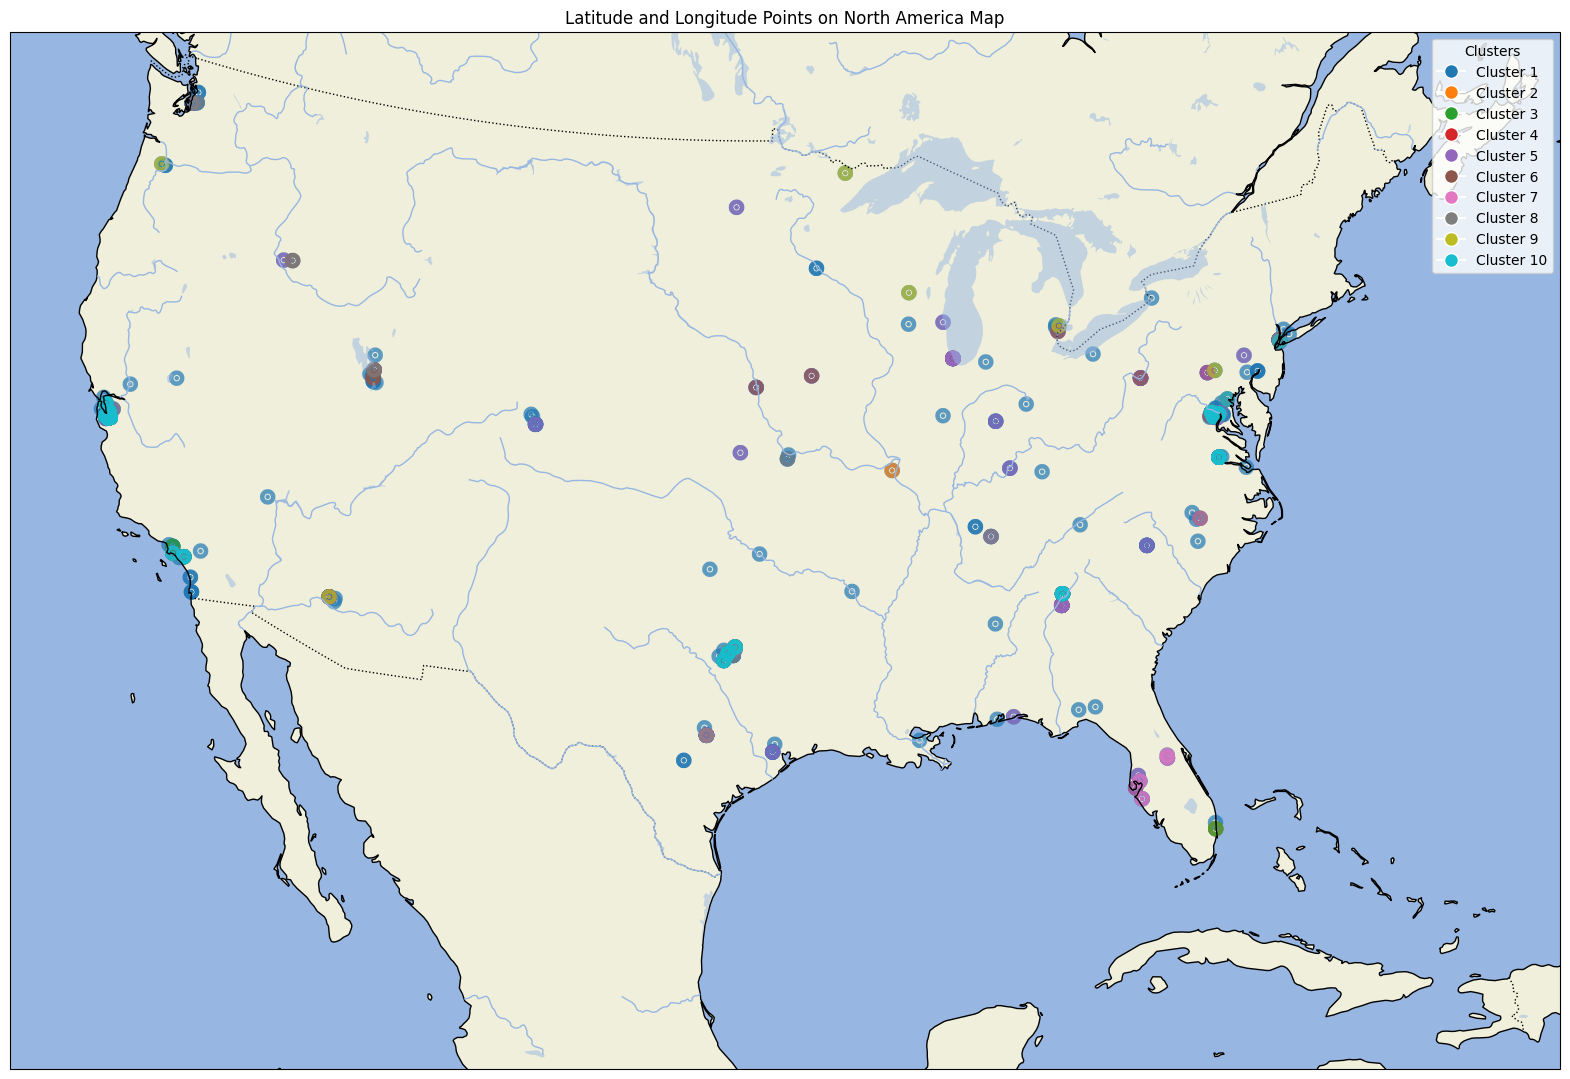

In [112]:
plot_north_america(filtered_df)

## Skill Transferability
identify each job id to be a certain cluster based on skill transferability clustering

In [31]:
import pandas as pd
from collections import Counter

In [63]:
df_postings_final = pd.read_csv('../processed_data/sde_postings_with_location.csv')

In [77]:
titles_to_clusters = {}
with open("txt_files/titles_to_clusters.txt", "r") as file:
    for line in file:
        cluster, title_list = line.strip().split(":")
        cluster = cluster[-1]
        title_list = title_list.strip()[1:-1]
        title_list = title_list.split(",")
        for title in title_list:
            title = title.strip()[1:-1]
            titles_to_clusters[title] = int(cluster)

In [78]:
def classify_job_posting(title):
    if title in titles_to_clusters:
        return titles_to_clusters[title]
    else:
        return -1

df_postings_final["cluster_id"] = df_postings_final["title"].apply(classify_job_posting)

In [79]:
df_postings_final["title"]

0      Embedded Software Engineer
1        Customer Success Manager
2       Content Marketing Manager
3                Network Engineer
4                   Test Engineer
                  ...            
611            Back End Developer
612             AI Content Writer
613            Back End Developer
614            Frontend Developer
615            Frontend Developer
Name: title, Length: 616, dtype: object

In [80]:
df_postings_final["cluster_id"].value_counts()

cluster_id
 3    302
 5    206
 4     49
 0     29
 1     23
-1      7
Name: count, dtype: int64

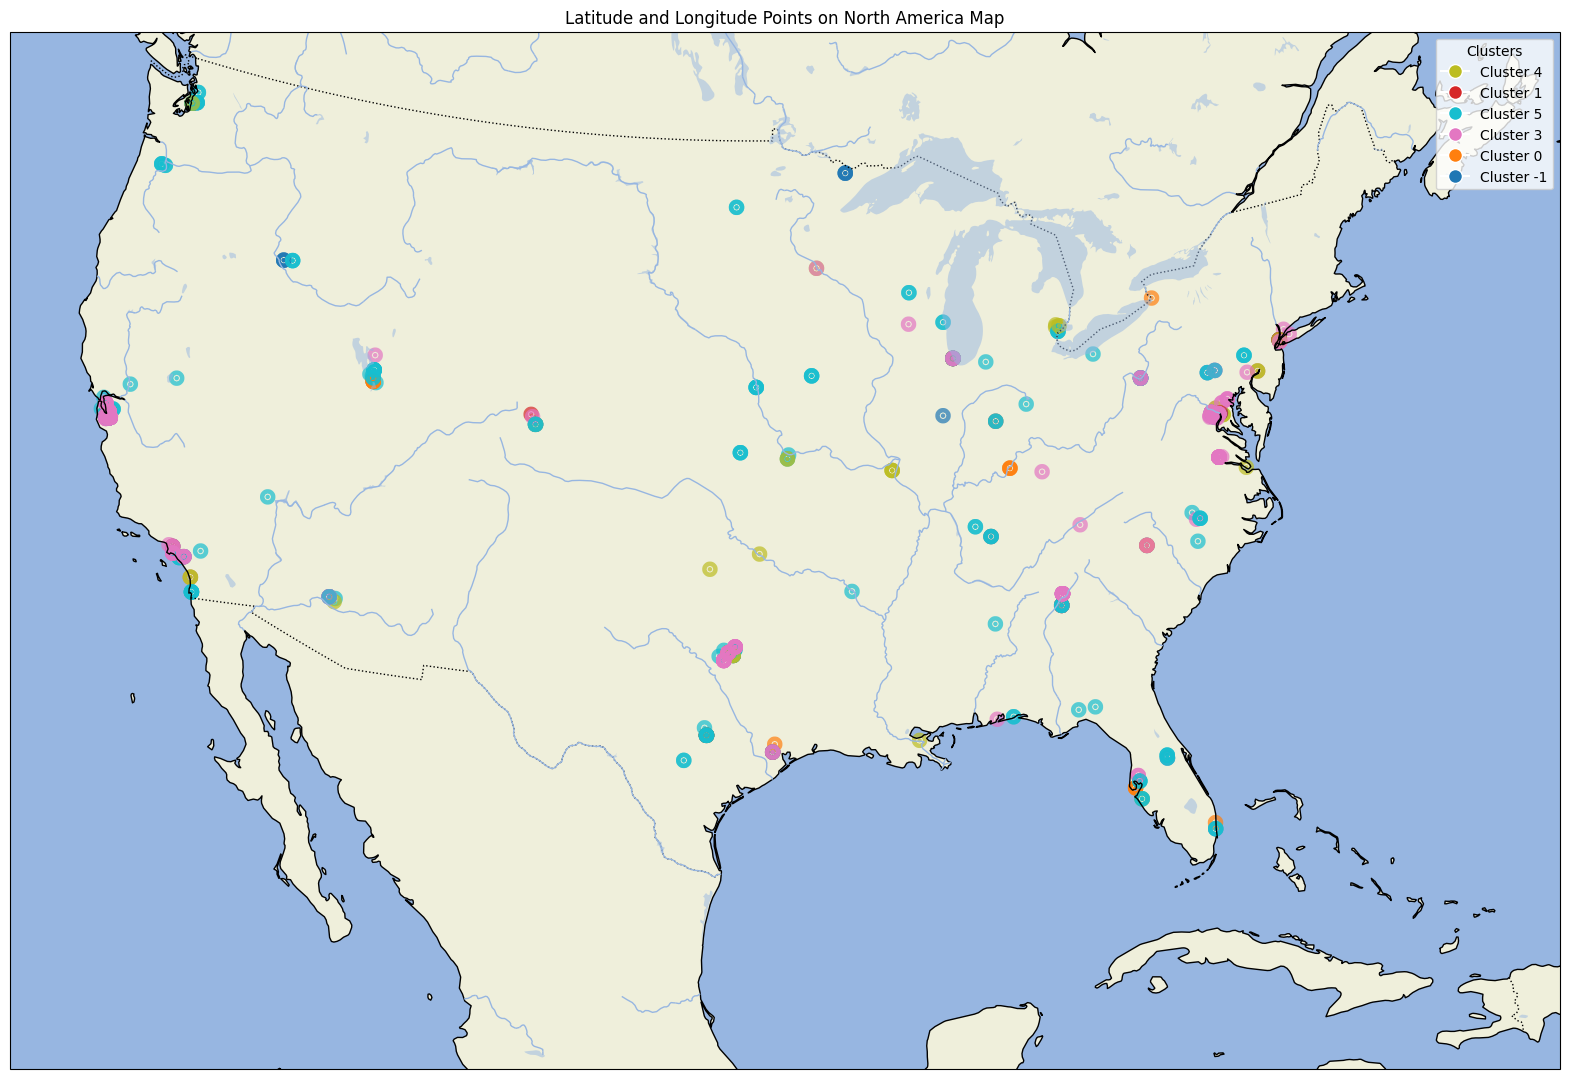

In [81]:
plot_north_america(df_postings_final)


## Clustering based on geolocation

In [55]:
import pandas as pd
import numpy as np

In [95]:
df_postings_final = pd.read_csv('../processed_data/filtered_1000_postings_with_location.csv')

In [73]:
from geopy.distance import great_circle

# Function to calculate distance matrix based on lat/long
def compute_distance_matrix(df):
    coords = df[['lat', 'long']].values
    n = len(coords)
    dist_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            dist = great_circle(coords[i], coords[j]).kilometers
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  

    return dist_matrix

distance_matrix = compute_distance_matrix(df_postings_final)


In [74]:
df_postings_final

,industry_id,industry_name,job_id,company_name,description,skills_desc,zip_code,skills,state,lat,long
0,47,Accounting,3885826587,CyberCoders,Job Title: International Tax Manager/Senior Ta...,NaN,15201.0,"['flexibility', 'leadership', 'planning', 'pla...",PA,40.4752,-79.9528
1,47,Accounting,3904097398,Brewer Morris,Senior Auditor/Supervisor opening in the Pitts...,NaN,15201.0,[],PA,40.4752,-79.9528
2,47,Accounting,3906249580,Frazier & Deeter,Join Frazier & Deeter and be a part of a rapid...,NaN,28202.0,['communication'],NC,35.2290,-80.8419
3,47,Accounting,3901181252,Brewer Morris,Exciting Remote Tax Manager opportunity!!!\nOu...,NaN,78701.0,[],TX,30.2713,-97.7426
4,47,Accounting,3901994753,BDO USA,Job Description\n\nJob Summary:\n\nBDO is a pl...,NaN,28202.0,"['initiative', 'leadership', 'communication', ...",NC,35.2290,-80.8419
...,...,...,...,...,...,...,...,...,...,...,...
1060,124,Wellness and Fitness Services,3901952931,Ageility,"Work With Purpose\n\nAt Ageility, we bring the...",NaN,33065.0,"['programming', 'empathy']",FL,26.2729,-80.2603
1061,124,Wellness and Fitness Services,3905390952,24 Hour Fitness,FULL-TIME Part-time\n\nLOCATION 17942 SW McEwa...,NaN,97062.0,"['programming', 'organization']",OR,45.3727,-122.7631
1062,124,Wellness and Fitness Services,3885100365,PedIM Healthcare,"Description:\n \nCompetitive Salary + $5,000 S...",NaN,32626.0,"['leadership', 'interpersonal', 'empathy', 'fl...",FL,29.4832,-82.8809
1063,124,Wellness and Fitness Services,3903429635,"Accolade, Inc.",About AccoladeAccolade (Nasdaq: ACCD) provides...,NaN,98101.0,"['communication', 'writing', 'communication', ...",WA,47.6114,-122.3305


### Creating the graph

In [75]:
# Convert DataFrame to dictionary with job_id as key
attrs = {
    row['job_id']: {
        'zipcode': row['zip_code'],
        'lat': row['lat'],
        'long': row['long'],
        'state': row['state'],
        'industry_name': row['industry_name'],
    }
    for _, row in df_postings_final.iterrows()
}


In [76]:
import networkx as nx

G = nx.Graph()

# Add nodes to the graph
for idx, row in df_postings_final.iterrows():
    G.add_node(row['job_id'])

jobs = df_postings_final['job_id'].tolist()

nx.set_node_attributes(G, attrs)

n = len(distance_matrix)
for i in range(n):
    for j in range(i + 1, n):
        if distance_matrix[i, j] > 0:  
            node1, node2 = jobs[i], jobs[j]
            G.add_edge(node1, node2, weight=distance_matrix[i, j])

In [60]:
nx.write_gml(G, '../graphs/location_graph_latlong.gml')

In [77]:
df_postings_final['state'].value_counts()

state
CA    138
TX    126
FL     71
NY     62
IL     57
VA     56
NC     48
PA     45
GA     37
OH     36
WA     33
AZ     32
MI     32
CO     30
MO     24
MD     23
IN     19
MN     18
TN     16
WI     13
AL     12
KY     11
KS     10
DC     10
IA      9
UT      9
NE      8
LA      7
NV      7
SC      7
AR      7
OR      7
NM      6
OK      6
WV      5
DE      5
HI      5
ID      4
MS      4
SD      3
AK      3
ND      2
WY      1
MT      1
Name: count, dtype: int64

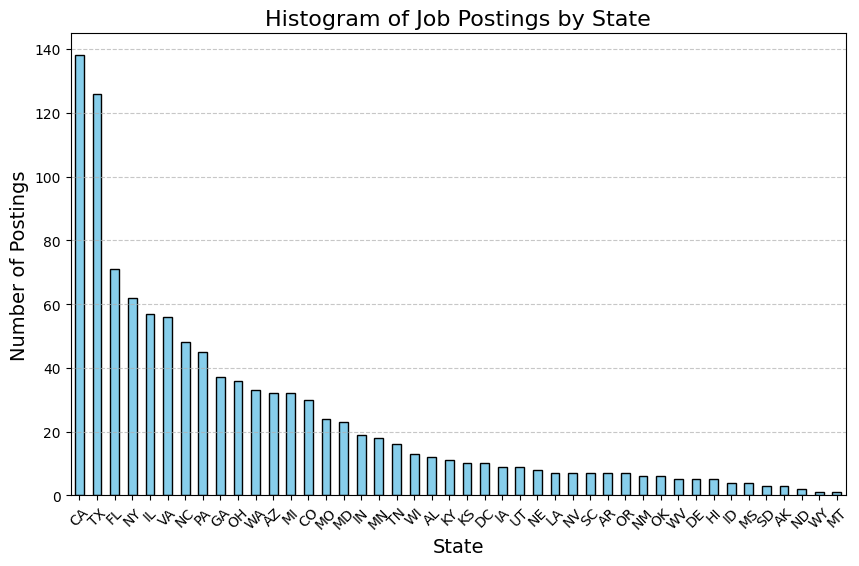

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
df_postings_final['state'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Histogram of Job Postings by State', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Postings', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


================ Community Analysis ================

Community 1: 328 nodes
Cut threshold: 15
Top 10 nodes by degree:
Node: IN, Degree: 1061
Node: NC, Degree: 1061
Node: PA, Degree: 1061
Node: OH, Degree: 1061
Node: NY, Degree: 1061
Node: NC, Degree: 1061
Node: MD, Degree: 1061
Node: MI, Degree: 1061
Node: VA, Degree: 1061
Node: DE, Degree: 1061

Community 2: 139 nodes
Cut threshold: 15
Top 10 nodes by degree:
Node: TX, Degree: 1061
Node: TX, Degree: 1061
Node: TX, Degree: 1061
Node: TX, Degree: 1061
Node: TX, Degree: 1061
Node: MS, Degree: 1061
Node: MS, Degree: 1061
Node: TX, Degree: 1061
Node: TX, Degree: 1061
Node: TX, Degree: 1061

Community 3: 239 nodes
Cut threshold: 15
Top 10 nodes by degree:
Node: CA, Degree: 1061
Node: OR, Degree: 1061
Node: ID, Degree: 1061
Node: CA, Degree: 1061
Node: AZ, Degree: 1061
Node: CA, Degree: 1061
Node: CA, Degree: 1061
Node: CA, Degree: 1061
Node: NV, Degree: 1061
Node: CA, Degree: 1061

Community 4: 75 nodes
Cut threshold: 15
Top 10 nodes by de

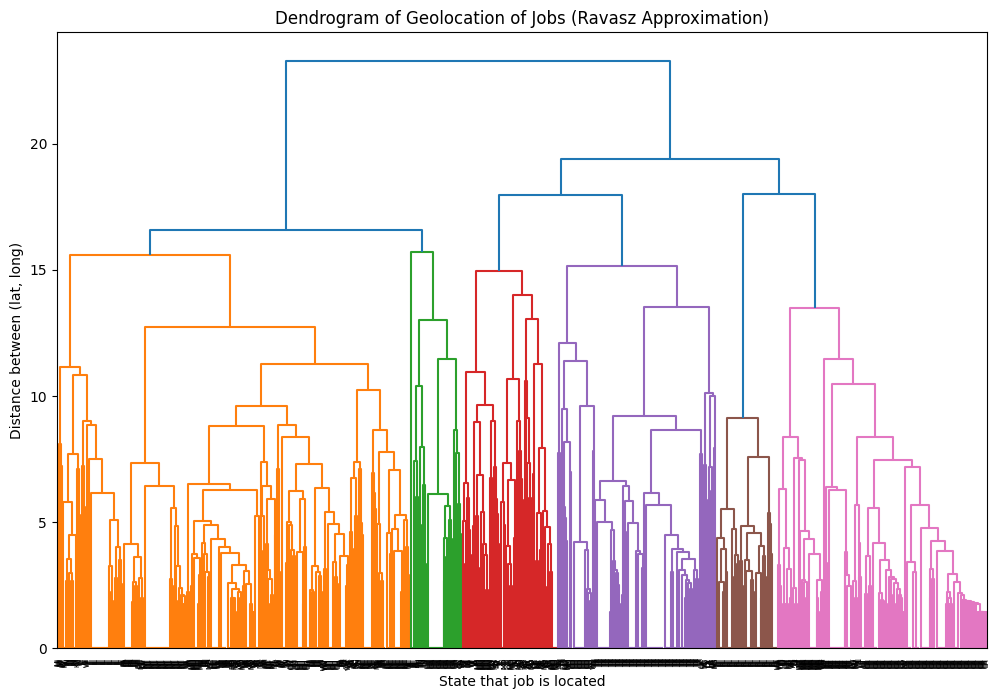

In [81]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

dist_threshold = 1000

# Define the similarity metric based on Ravasz's idea:
def calculate_similarity(u, v):
    if G.has_edge(u, v):
        edge_weight = G[u][v]['weight']
        if edge_weight < dist_threshold:
            return 1
        else:
            return 0
    else:
        return 0

# Create a similarity matrix for hierarchical clustering
nodes = list(G.nodes())
similarity_matrix = np.zeros((len(nodes), len(nodes)))

for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        if i < j:  # Avoid redundant calculations
            similarity = calculate_similarity(u, v)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Symmetric matrix

# Convert similarity to distance (1 - similarity) for clustering
distance_matrix = 1 - similarity_matrix
distance_array = pdist(distance_matrix)

# Form the dendrogram using hierarchical clustering (average linkage)
Z = linkage(distance_array, method='average')

# Plot dendrogram
plt.figure(figsize=(12, 8))
states = [G.nodes()[node]["state"] for node in G.nodes()]
dendrogram(Z, labels=states, leaf_rotation=90)
plt.title("Dendrogram of Geolocation of Jobs (Ravasz Approximation)")
plt.xlabel("State that job is located")
plt.ylabel("Distance between (lat, long)")
# plt.savefig("figures/ravasz_dendrogram.jpg")

# Define a parameter to "cut" the dendrogram and form communities
cut_threshold = 15  # Adjust this to control the community granularity
clusters = fcluster(Z, cut_threshold, criterion='distance')

# Print out the communities in the same format
community_dict = {}
for node, cluster_id in zip(nodes, clusters):
    if cluster_id not in community_dict:
        community_dict[cluster_id] = []
    community_dict[cluster_id].append(node)

print("================ Community Analysis ================\n")
for i, (cluster_id, community_nodes) in enumerate(community_dict.items(), 1):
    community_subgraph = G.subgraph(community_nodes)
    print(f"Community {i}: {len(community_nodes)} nodes")
    print(f"Cut threshold: {cut_threshold}")
    
    # Sort nodes by degree and select top 10 by degree within the community
    top_10_nodes = sorted(
        [(node, G.degree[node]) for node in community_nodes],
        key=lambda x: x[1],
        reverse=True
    )[:10]

    print("Top 10 nodes by degree:")
    for node, degree in top_10_nodes:
        state = G.nodes()[node]["state"]
        print(f"Node: {state}, Degree: {degree}")
    print("=========================================\n")

In [82]:
# Number of communities
print(f"Number of communities: {len(community_dict.keys())}")


Number of communities: 9


In [83]:
# Assign the cluster name to a new column in the df
node_to_cluster = {}
for cluster_id, community_nodes in community_dict.items():
    for node in community_nodes:
        node_to_cluster[node] = cluster_id
df_postings_final['cluster_id'] = df_postings_final['job_id'].map(node_to_cluster)

df_postings_final

,industry_id,industry_name,job_id,company_name,description,skills_desc,zip_code,skills,state,lat,long,cluster_id
0,47,Accounting,3885826587,CyberCoders,Job Title: International Tax Manager/Senior Ta...,NaN,15201.0,"['flexibility', 'leadership', 'planning', 'pla...",PA,40.4752,-79.9528,2
1,47,Accounting,3904097398,Brewer Morris,Senior Auditor/Supervisor opening in the Pitts...,NaN,15201.0,[],PA,40.4752,-79.9528,2
2,47,Accounting,3906249580,Frazier & Deeter,Join Frazier & Deeter and be a part of a rapid...,NaN,28202.0,['communication'],NC,35.2290,-80.8419,2
3,47,Accounting,3901181252,Brewer Morris,Exciting Remote Tax Manager opportunity!!!\nOu...,NaN,78701.0,[],TX,30.2713,-97.7426,7
4,47,Accounting,3901994753,BDO USA,Job Description\n\nJob Summary:\n\nBDO is a pl...,NaN,28202.0,"['initiative', 'leadership', 'communication', ...",NC,35.2290,-80.8419,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1060,124,Wellness and Fitness Services,3901952931,Ageility,"Work With Purpose\n\nAt Ageility, we bring the...",NaN,33065.0,"['programming', 'empathy']",FL,26.2729,-80.2603,8
1061,124,Wellness and Fitness Services,3905390952,24 Hour Fitness,FULL-TIME Part-time\n\nLOCATION 17942 SW McEwa...,NaN,97062.0,"['programming', 'organization']",OR,45.3727,-122.7631,9
1062,124,Wellness and Fitness Services,3885100365,PedIM Healthcare,"Description:\n \nCompetitive Salary + $5,000 S...",NaN,32626.0,"['leadership', 'interpersonal', 'empathy', 'fl...",FL,29.4832,-82.8809,8
1063,124,Wellness and Fitness Services,3903429635,"Accolade, Inc.",About AccoladeAccolade (Nasdaq: ACCD) provides...,NaN,98101.0,"['communication', 'writing', 'communication', ...",WA,47.6114,-122.3305,9


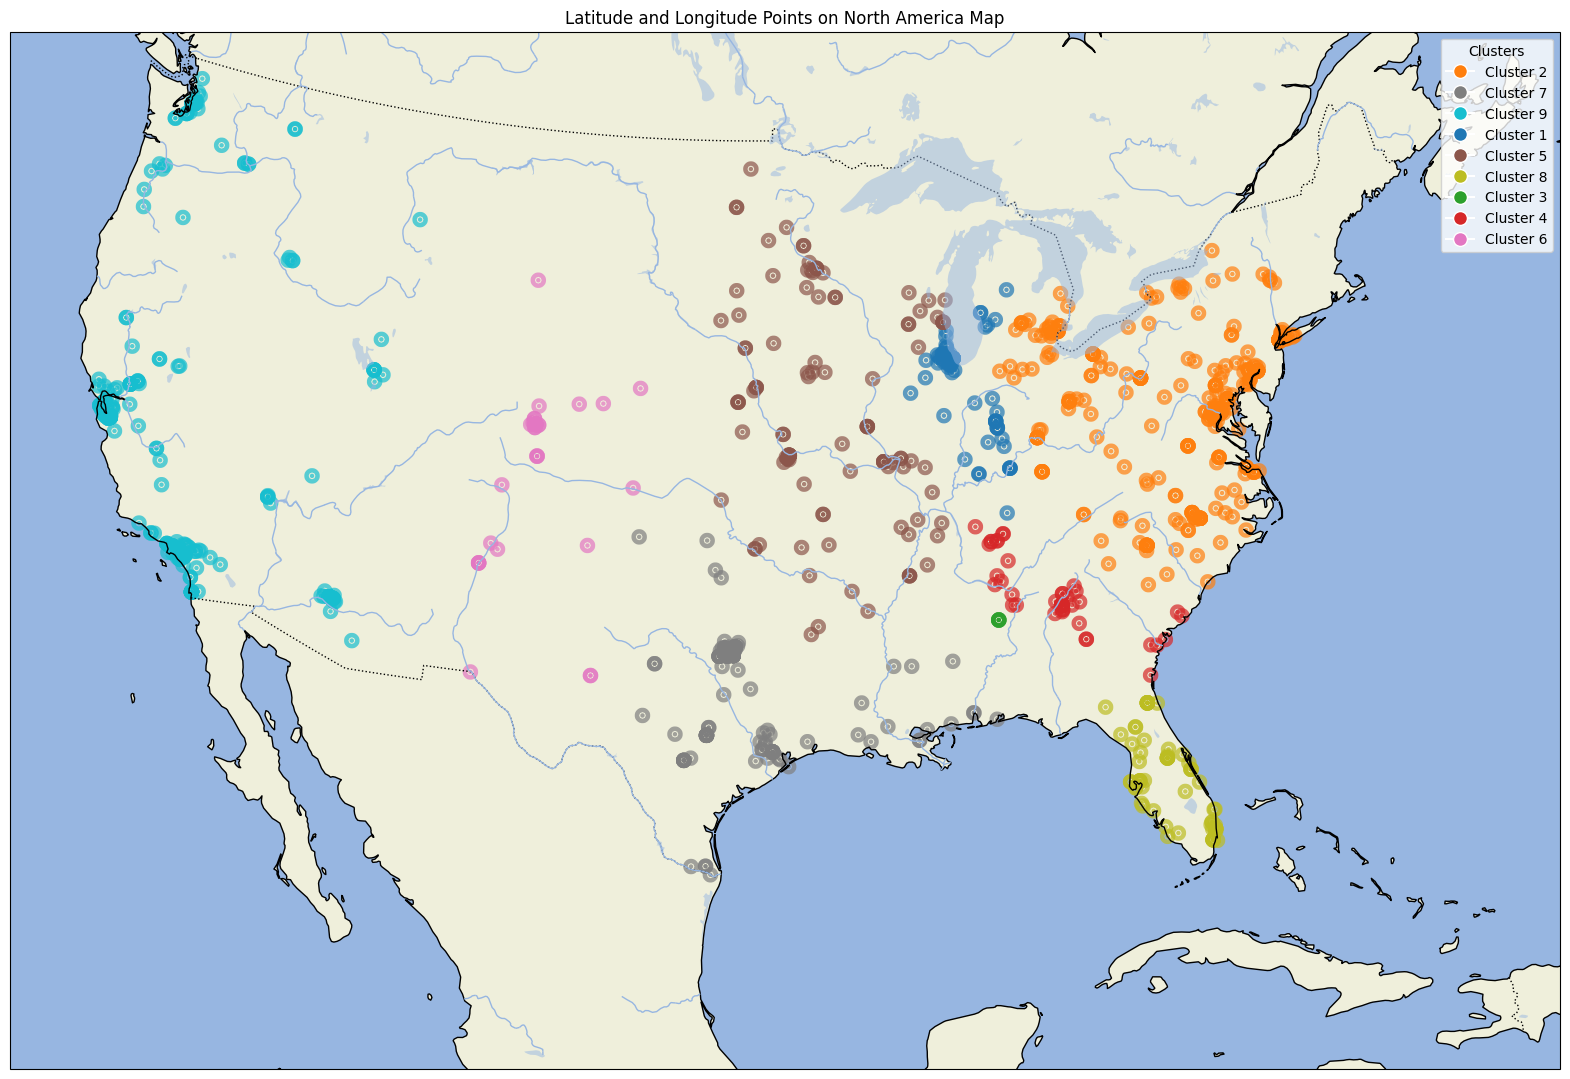

In [84]:
plot_north_america(df_postings_final)


## Skill analysis
identify each job id to be a certain cluster based on the number of skills and which cluster most of the skill belongs to 
Assign that job id to be in that cluster

In [86]:
import pandas as pd
from collections import Counter

In [ ]:
df_postings_final = pd.read_csv('../processed_data/filtered_1000_postings_with_location.csv')

In [89]:
df_postings_final_with_skills = df_postings_final

In [90]:
skills_to_clusters = {}
with open("txt_files/skills_to_clusters.txt", "r") as file:
    next(file)  # Skip the header row
    for line in file:
        skill, cluster = line.strip().split("\t")
        skills_to_clusters[skill] = int(cluster)

In [91]:
def classify_job_posting(skill_list):
    cluster_counts = Counter()
    for skill in skill_list:
        if skill in skills_to_clusters:
            cluster_counts[skills_to_clusters[skill]] += 1
    return cluster_counts.most_common(1)[0][0] if cluster_counts else -1

df_postings_final_with_skills["cluster_id"] = df_postings_final_with_skills["skills"].apply(classify_job_posting)

In [92]:
df_postings_final_with_skills["cluster_id"].value_counts()

cluster_id
 3    441
 1    368
-1    256
Name: count, dtype: int64

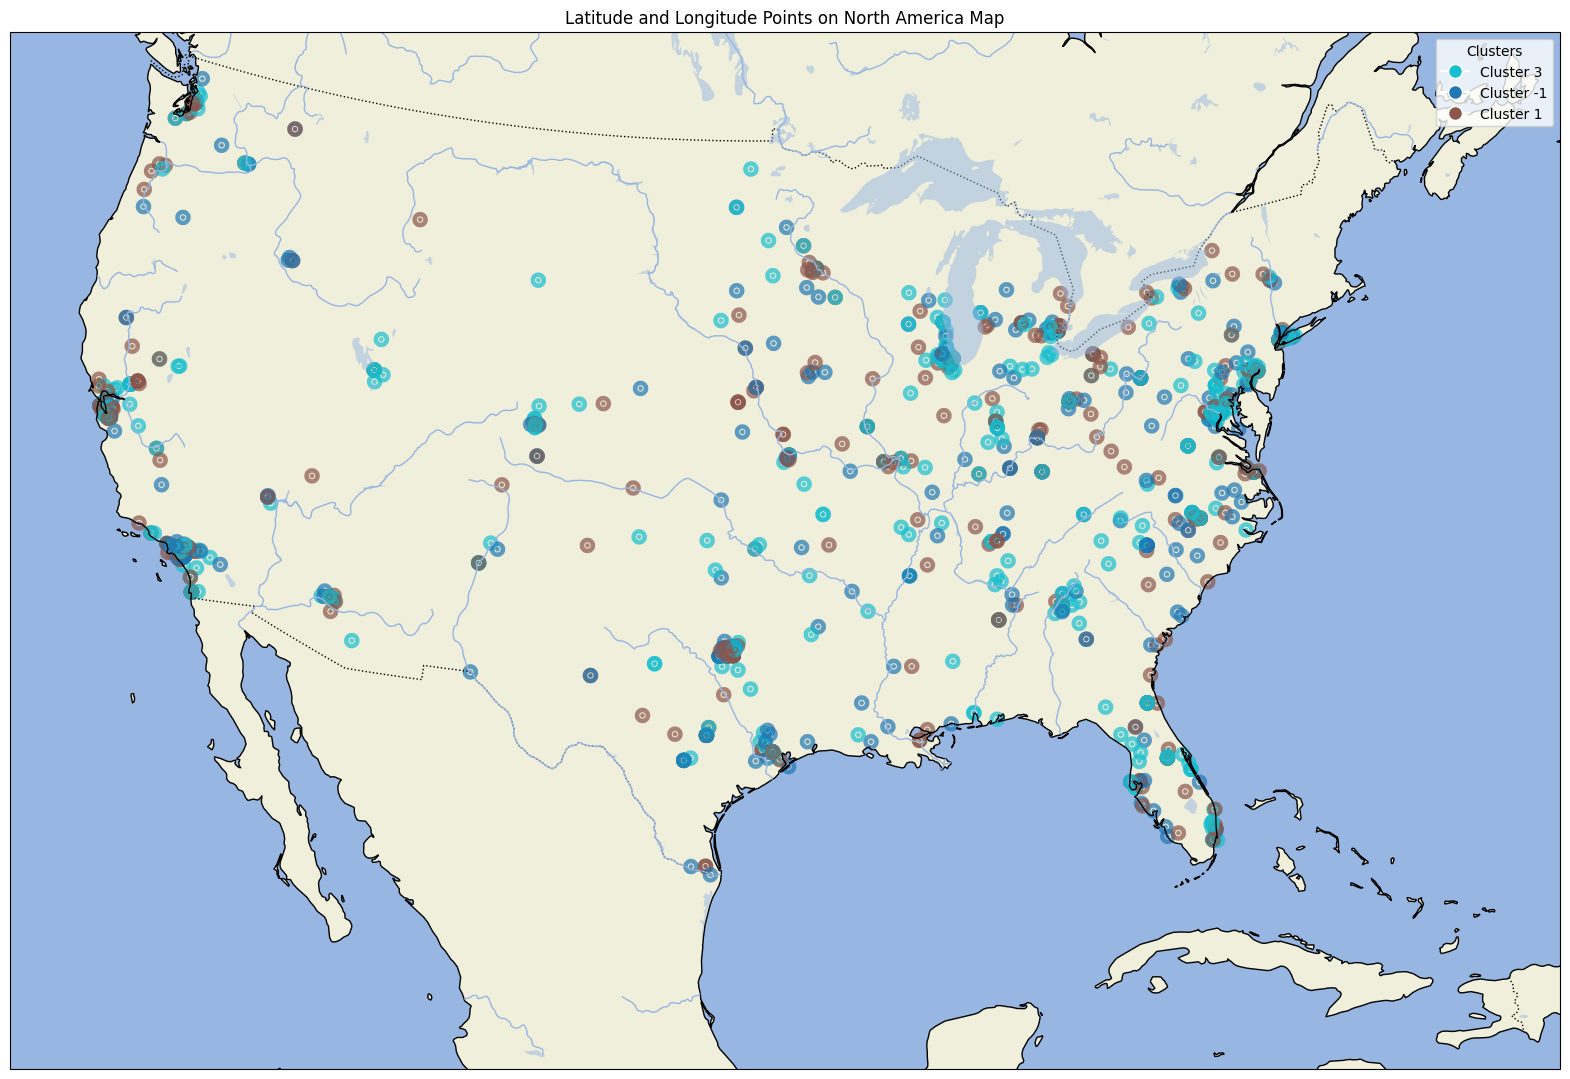

In [93]:
plot_north_america(df_postings_final_with_skills)
